<a href="https://colab.research.google.com/github/aai510-group1/project/blob/main/Project_Telco_updated_dina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%pip install --quiet --progress-bar=off uv

In [ ]:
#!uv pip install --system --upgrade --quiet datasets
#from datasets import load_dataset
#dataset = load_dataset('aai510-group1/dataset', token=False)
#df_train = dataset['train'].to_pandas()
#df_test = dataset['test'].to_pandas()
#df_val = dataset['validation'].to_pandas()

In [1]:
pip install xgboost

In [2]:
pip install tensorflow

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [21]:
df = pd.read_csv('dataset.csv')
df.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,Churn Category,Churn Label,Churn Reason,Churn Score,Churn Value,City,CLTV,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code
0,78,8,0.00,Competitor,Yes,Competitor offered more data,91,1,Los Angeles,5433,...,No,1,39.65,20,0.00,0.0,59.65,No,No,90022
1,39,18,42.55,NaN,No,NaN,42,0,Los Angeles,4658,...,No,72,5016.65,0,3063.60,0.0,8080.25,No,Yes,90022
2,32,26,7.11,NaN,No,NaN,34,0,Los Angeles,3503,...,No,1,75.55,0,7.11,0.0,82.66,No,Yes,90022
3,35,25,0.00,NaN,No,NaN,46,0,Los Angeles,5748,...,Yes,66,3708.40,0,0.00,0.0,3708.40,No,Yes,90022
4,20,42,36.49,NaN,No,NaN,38,0,Los Angeles,5545,...,Yes,7,633.45,0,255.43,0.0,888.88,Yes,Yes,90022


# Preprocessing  

In [22]:
# drop customer ID , Count, Country , State since they are not relevant to the analysis. All in US, CA
df.drop(columns=['Customer ID','Country','State'], inplace=True)
# drop variables that are leaking the Target variable
df.drop(columns=['Churn Label','Churn Score','Churn Reason','Churn Category','Customer Status'], inplace=True)


In [23]:
# find non-numerical features and convert to numerical features
# Find non-numerical features
non_numerical_features = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each non-numerical feature and perform label encoding
for feature in non_numerical_features:
    df[feature] = label_encoder.fit_transform(df[feature])


# Display the first few rows after label encoding
print("First 5 rows after label encoding:")
print(df.head())

First 5 rows after label encoding:
   Age  Avg Monthly GB Download  Avg Monthly Long Distance Charges  \
0   78                        8                               0.00   
1   39                       18                              42.55   
2   32                       26                               7.11   
3   35                       25                               0.00   
4   20                       42                              36.49   

   Churn Value  City  CLTV  Contract  Dependents  Device Protection Plan  \
0            1   554  5433         0           0                       1   
1            0   554  4658         2           0                       1   
2            0   554  3503         0           0                       1   
3            0   554  5748         2           1                       1   
4            0   554  5545         1           0                       0   

   Gender  ...  Streaming TV  Tenure in Months  Total Charges  \
0       1  ...        

In [24]:
# Summary statistics
print("Summary statistics:")
print(df.describe())

Summary statistics:
               Age  Avg Monthly GB Download  \
count  7043.000000              7043.000000   
mean     46.509726                20.515405   
std      16.750352                20.418940   
min      19.000000                 0.000000   
25%      32.000000                 3.000000   
50%      46.000000                17.000000   
75%      60.000000                27.000000   
max      80.000000                85.000000   

       Avg Monthly Long Distance Charges  Churn Value         City  \
count                        7043.000000  7043.000000  7043.000000   
mean                           22.958954     0.265370   588.042879   
std                            15.448113     0.441561   307.797647   
min                             0.000000     0.000000     0.000000   
25%                             9.210000     0.000000   331.000000   
50%                            22.890000     0.000000   604.000000   
75%                            36.395000     1.000000   854.000000

In [25]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values)


Missing values:
Age                                  0
Avg Monthly GB Download              0
Avg Monthly Long Distance Charges    0
Churn Value                          0
City                                 0
CLTV                                 0
Contract                             0
Dependents                           0
Device Protection Plan               0
Gender                               0
Internet Service                     0
Internet Type                        0
Lat Long                             0
Latitude                             0
Longitude                            0
Married                              0
Monthly Charge                       0
Multiple Lines                       0
Number of Dependents                 0
Number of Referrals                  0
Offer                                0
Online Backup                        0
Online Security                      0
Paperless Billing                    0
Partner                              0
Payment 

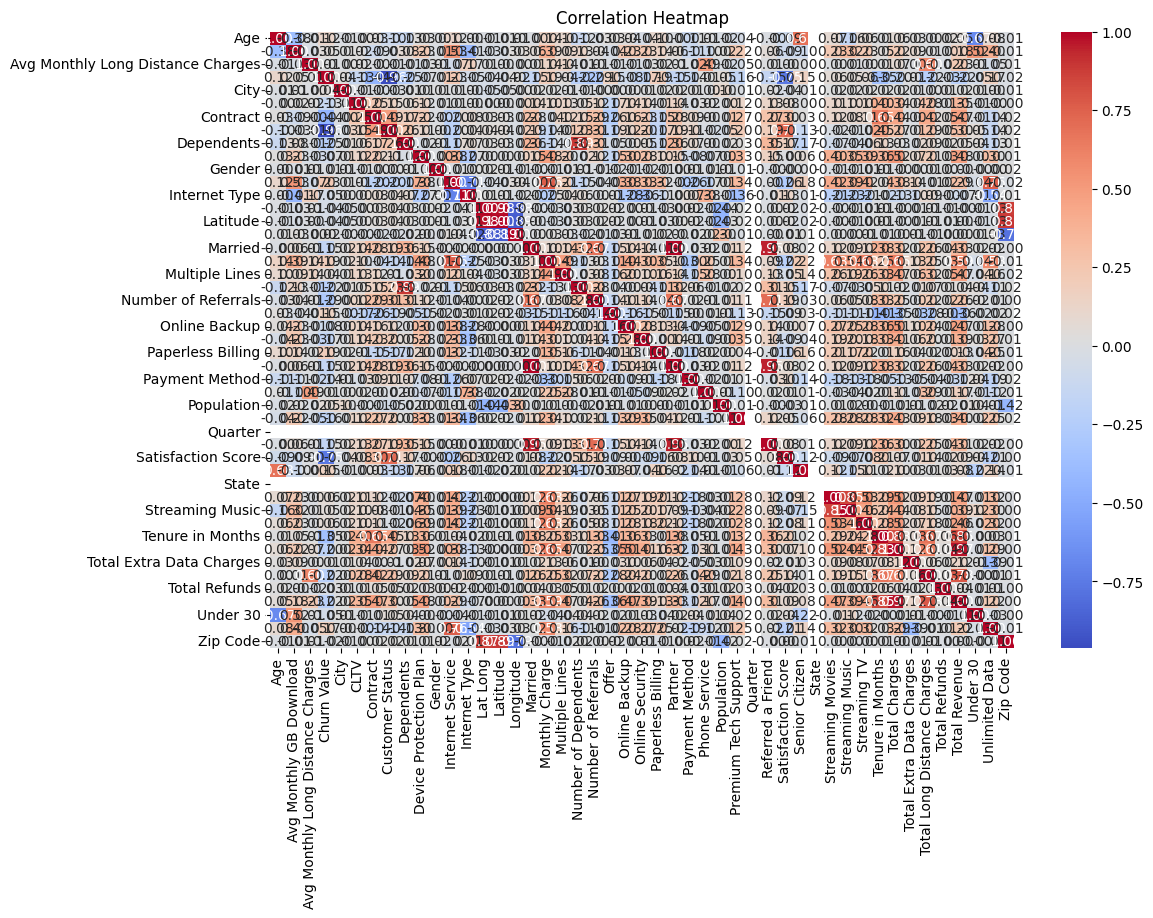

In [15]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

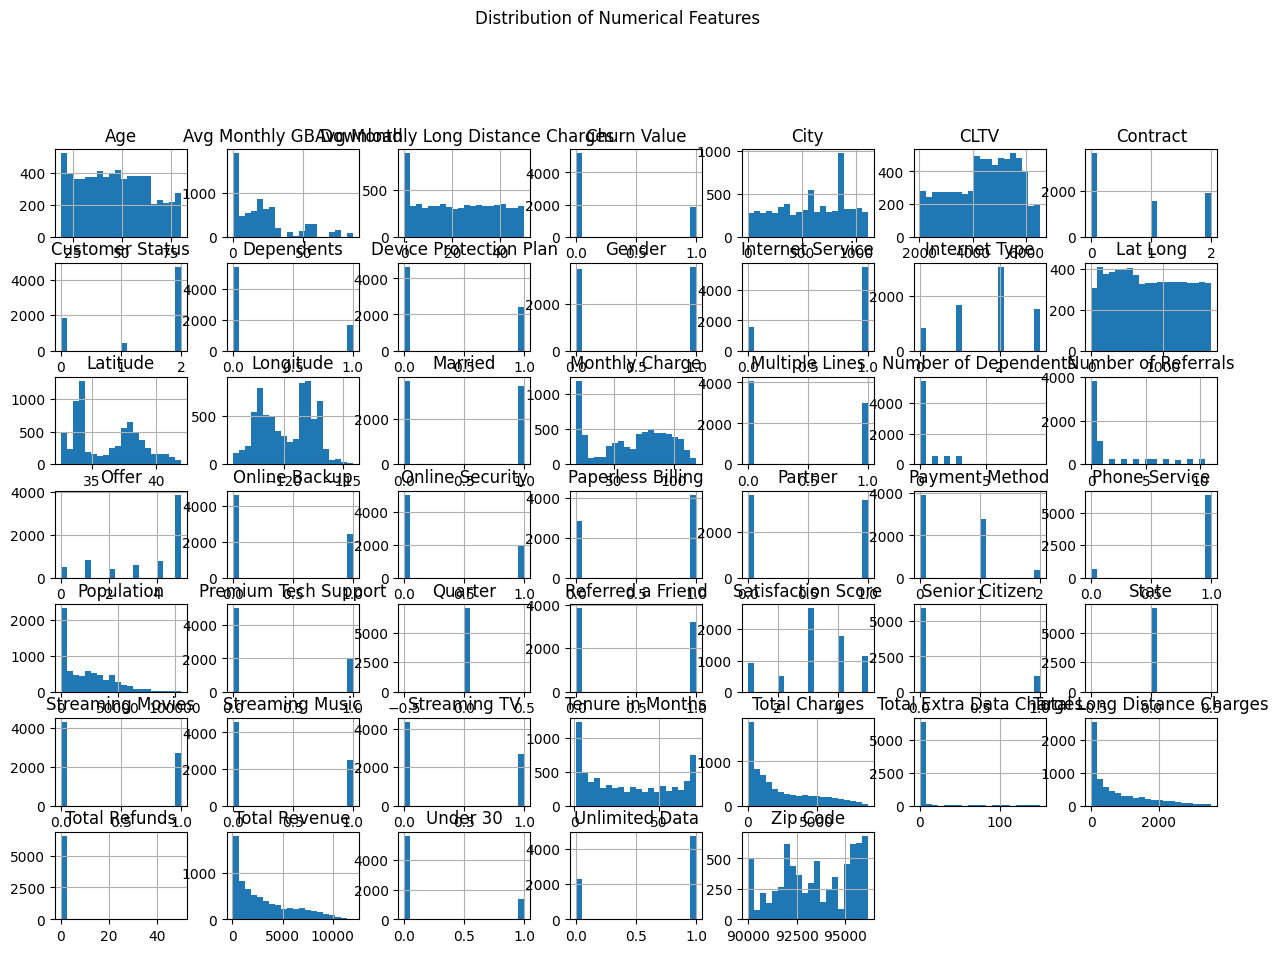

In [16]:
# Distribution of numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', x=0.5, y=1.02, ha='center', fontsize='large')
plt.show()

# Baseline Prediction using Decision Tree

In [26]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Churn Value'])
y = df['Churn Value']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)

# Evaluate Decision Tree model
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_f1 = f1_score(y_test, dt_y_pred)
dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
print("Baseline Decision Tree Metrics:")
print(f"Accuracy: {dt_accuracy}")
print(f"Precision: {dt_precision}")
print(f"Recall: {dt_recall}")
print(f"F1 Score: {dt_f1}")
print(f"Confusion Matrix:{dt_conf_matrix}")
print(f'AUC: {dt_roc_auc }')
print(dt_conf_matrix)

Baseline Decision Tree Metrics:
Accuracy: 0.9410929737402413
Precision: 0.875
Recall: 0.9098143236074271
F1 Score: 0.8920676202860859
Confusion Matrix:[[983  49]
 [ 34 343]]
AUC: 0.9311668517261941
[[983  49]
 [ 34 343]]


In [27]:
X_train.head()

,Age,Avg Monthly GB Download,Avg Monthly Long Distance Charges,City,CLTV,Contract,Dependents,Device Protection Plan,Gender,Internet Service,...,Streaming TV,Tenure in Months,Total Charges,Total Extra Data Charges,Total Long Distance Charges,Total Refunds,Total Revenue,Under 30,Unlimited Data,Zip Code
2142,80,27,44.23,765,4295,2,0,1,1,1,...,1,65,7246.15,0,2874.95,0.00,10121.10,0,1,93256
1623,59,21,7.84,785,4268,1,1,0,0,1,...,1,69,4885.85,0,540.96,0.00,5426.81,0,1,94028
6074,63,18,30.09,854,2675,1,0,0,0,1,...,1,38,3342.00,90,1143.42,0.00,4575.42,0,0,92101
1362,38,13,32.57,24,3581,0,0,1,0,1,...,0,9,653.90,0,293.13,2.28,944.75,0,1,96007
6754,22,82,0.00,707,4296,1,0,0,1,1,...,1,26,1362.85,0,0.00,0.00,1362.85,1,1,95555


# Prediction using XGboost

In [28]:
# XGBoost Classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

print("\nXGBoost Classifier Metrics:")
print(f"Accuracy: {xgb_accuracy}")
print(f"Precision: {xgb_precision}")
print(f"Recall: {xgb_recall}")
print(f"F1 Score: {xgb_f1}")
print("Confusion Matrix:")
print(xgb_conf_matrix)


XGBoost Classifier Metrics:
Accuracy: 0.957416607523066
Precision: 0.9490084985835694
Recall: 0.8885941644562334
F1 Score: 0.9178082191780821
Confusion Matrix:
[[1014   18]
 [  42  335]]


# Hyperparam to optimize Xgboost

In [29]:
 #Define parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict using the best model
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nBest XGBoost Classifier Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.966276806498335

Best XGBoost Classifier Metrics:
Accuracy: 0.9581263307310149
Precision: 0.9517045454545454
Recall: 0.8885941644562334
F1 Score: 0.9190672153635117
Confusion Matrix:
[[1015   17]
 [  42  335]]


# Predicting using Deep Neural Networks

In [35]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the deep neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Deep Neural Network Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/50
141/141 [==============================] - 2s 4ms/step - loss: 0.2815 - accuracy: 0.8835 - val_loss: 0.1342 - val_accuracy: 0.9459
Epoch 2/50
141/141 [==============================] - 0s 3ms/step - loss: 0.1229 - accuracy: 0.9521 - val_loss: 0.1082 - val_accuracy: 0.9547
Epoch 3/50
141/141 [==============================] - 0s 3ms/step - loss: 0.0950 - accuracy: 0.9638 - val_loss: 0.1036 - val_accuracy: 0.9601
Epoch 4/50
141/141 [==============================] - 1s 4ms/step - loss: 0.0845 - accuracy: 0.9663 - val_loss: 0.1074 - val_accuracy: 0.9539
Epoch 5/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0770 - accuracy: 0.9705 - val_loss: 0.0971 - val_accuracy: 0.9601
Epoch 6/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0670 - accuracy: 0.9745 - val_loss: 0.1011 - val_accuracy: 0.9618
Epoch 7/50
141/141 [==============================] - 1s 5ms/step - loss: 0.0659 - accuracy: 0.9727 - val_loss: 0.1041 - val_accuracy: 0.9618
Epoch 